In [14]:
import polars as pl
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import statistics
from numpy import typing as npt
import more_itertools as mit
from returns.curry import partial

In [2]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()

In [3]:
df = pl.read_csv(TRAIN_FILE_PATH)
df


id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
i64,i64,str,i64,str,i64,i64,str,i64,i64,str,i64,i64,i64,str,i64,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,36,"""Travel_Frequen...",599,"""Research & Dev...",24,3,"""Medical""",1,4,"""Male""",42,3,1,"""Laboratory Tec...",4,"""Married""",2596,5099,1,"""Y""","""Yes""",13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,"""Travel_Rarely""",921,"""Sales""",8,3,"""Other""",1,1,"""Male""",46,3,1,"""Sales Represen...",1,"""Married""",2899,10778,1,"""Y""","""No""",17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,"""Travel_Rarely""",718,"""Sales""",26,3,"""Marketing""",1,3,"""Male""",80,3,2,"""Sales Executiv...",4,"""Divorced""",4627,16495,0,"""Y""","""No""",17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,"""Travel_Rarely""",1488,"""Research & Dev...",2,3,"""Medical""",1,3,"""Female""",40,3,2,"""Healthcare Rep...",1,"""Married""",5347,13384,3,"""Y""","""No""",14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,"""Travel_Rarely""",1017,"""Research & Dev...",5,4,"""Medical""",1,2,"""Female""",37,3,5,"""Manager""",1,"""Single""",19033,19805,1,"""Y""","""Yes""",13,3,3,80,0,31,0,3,31,14,4,10,1
5,27,"""Travel_Rarely""",566,"""Research & Dev...",2,3,"""Other""",1,3,"""Female""",56,3,2,"""Manufacturing ...",2,"""Single""",4197,7103,5,"""Y""","""No""",11,3,4,80,0,6,0,3,1,0,1,0,0
6,34,"""Travel_Rarely""",944,"""Research & Dev...",10,4,"""Medical""",1,2,"""Male""",36,3,1,"""Laboratory Tec...",1,"""Single""",1281,16900,1,"""Y""","""No""",13,3,1,80,0,1,2,3,1,0,0,0,0
7,40,"""Travel_Rarely""",1009,"""Research & Dev...",2,3,"""Life Sciences""",1,4,"""Male""",74,3,1,"""Laboratory Tec...",4,"""Divorced""",3067,12916,2,"""Y""","""No""",12,3,4,80,1,6,3,2,3,2,1,2,0
8,51,"""Travel_Frequen...",1297,"""Sales""",6,3,"""Life Sciences""",1,4,"""Male""",43,1,2,"""Sales Executiv...",4,"""Married""",6439,21221,8,"""Y""","""Yes""",13,3,1,80,1,18,3,3,16,14,4,9,0


In [4]:
df.null_count()

id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
def plot_counts_and_target_factor(df: pl.DataFrame, *, target_column_name: str, column_name: str) -> None:
    target_values = df.select(pl.col(target_column_name).unique().alias('target')).sort('target')['target']
    aggs = [pl.count().alias('count')]
    for target_value in target_values:
        aggs.append(
            (
                pl.col(target_column_name).filter(
                    pl.col(target_column_name) == target_value
                ).count() / pl.count()
            ).alias(f'count_{target_value}_factor')
        )
    grouped_df = df.groupby([column_name]).agg(aggs).sort(["count"])
    # create side by side plots
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    indices = np.arange(len(grouped_df))
    bars = left_ax.barh(indices, grouped_df['count'])
    left_ax.set_yticks(indices, grouped_df[column_name])
    left_ax.bar_label(bars, fmt='%d')

    prev_series: pl.Series | None = None
    for target_value in target_values:
        series = grouped_df[f'count_{target_value}_factor']
        right_ax.barh(indices, series, label=f'{target_column_name}={target_value}', left=prev_series)
        prev_series = series
    right_ax.legend()

    plt.title(f"Counts for {column_name}")


In [15]:
def plot_histogram_and_target_factor(df: pl.DataFrame, *, target_column_name: str, column_name: str, bins: int | None = None) -> None:
    if bins is None:
        # automatically adjust the number of bins
        n_unique_values = df.select(pl.col(column_name).n_unique()).item()
        bins = min(n_unique_values, 20)

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5))
    total_series = df[column_name]
    (hist, brackets, _) = left_ax.hist(total_series, bins=bins)
    x = list(map(statistics.mean, mit.sliding_window(brackets, 2)))
    bracket_width = brackets[1] - brackets[0]

    target_values = df.select(pl.col(target_column_name).unique().alias('target')).sort('target')['target']
    series = (
        df.filter(pl.col(target_column_name) == target_value)[column_name]
        for target_value in target_values
    )
    histograms = (
        np.histogram(series, bins=brackets)[0]
        for series in series
    )
    factors = (
        histogram / hist
        for histogram in histograms
    )
    prev_factor: npt.NDarray[np.float64] | None = None
    for target_value, factor in zip(target_values, factors):
        right_ax.bar(x, factor, width=bracket_width, label=f'{target_column_name}={target_value}', bottom=prev_factor)
        prev_factor = factor
    right_ax.legend()
    
    plt.title(f'{column_name} distribution')

In [20]:
plot_counts = partial(plot_counts_and_target_factor, df, target_column_name='Attrition')
plot_histogram = partial(plot_histogram_and_target_factor, df, target_column_name='Attrition')

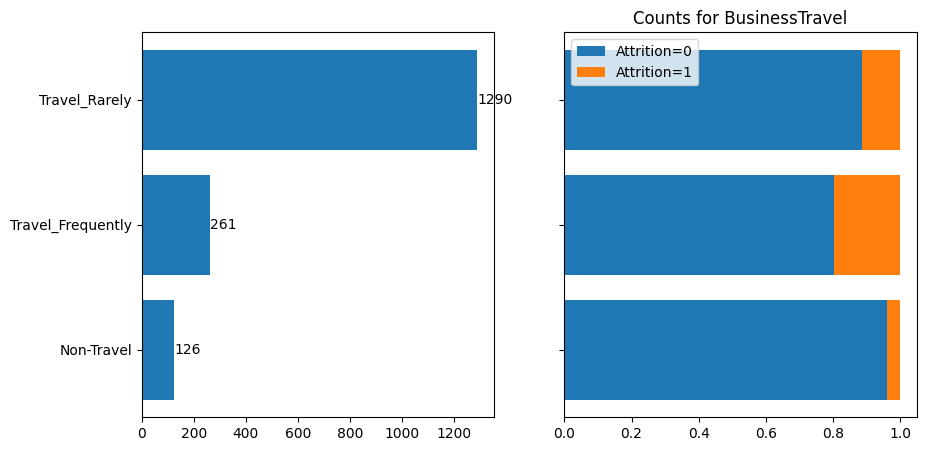

In [19]:
plot_counts(column_name='BusinessTravel')

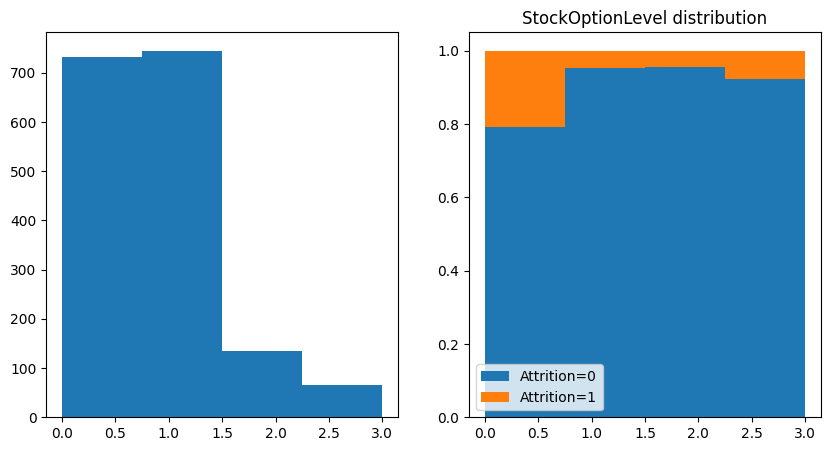

In [21]:
plot_histogram(column_name='StockOptionLevel')

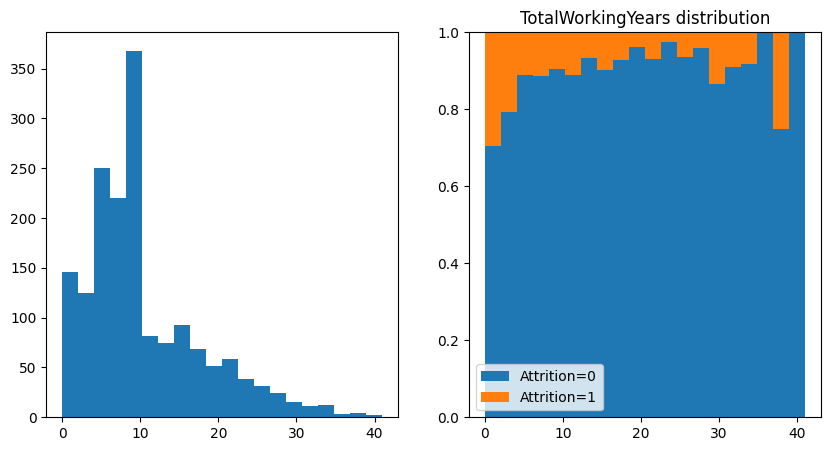

In [23]:
plot_histogram(column_name='TotalWorkingYears')

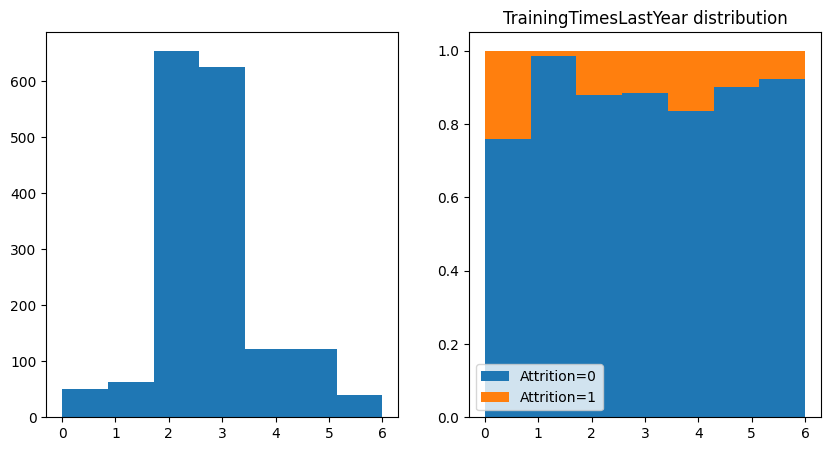

In [25]:
plot_histogram(column_name='TrainingTimesLastYear')

In [ ]:
dict(zip(df.columns, df.dtypes))

In [ ]:
plot_counts('heart_disease')

In [ ]:
plot_counts('ever_married')

In [ ]:
_ = plt.hist(df.filter(pl.col('ever_married') == 'Yes').select(pl.col('age')), bins=40)

There are some kids marked as married

In [ ]:
plot_counts('work_type')

In [ ]:
_ = plt.hist(df.filter(pl.col('work_type') == 'children').select(pl.col('age')), bins=40)

There are some old people incorrectly assigned to work type.

In [ ]:
plot_counts('Residence_type')

In [ ]:
plot_histogram('avg_glucose_level', bins=20)

In [ ]:
plot_histogram('bmi', bins=20)

In [ ]:
plot_counts('smoking_status')

In [ ]:
plot_counts('stroke')